In [1]:
library(data.table)
library(sf)
# remove.packages( 'terra')
# install.packages('rgdal')
library(magrittr)
library(ggplot2)

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1



In [3]:
# conn <- RPostgreSQL::dbConnect("PostgreSQL",
#                             host = 'mild-williams-pear.db.elephantsql.com',
#                             dbname = "jifesypi",
#                             user = "jifesypi",
#                             password ="Qxds23zjkpIIU343-GGHNlxqFdD3Pdlr")
# # dist_list <- b_dist
# # b_dist <- max(b_dist)

# # query_wkt <- st_as_text(parcel_dt$geom , EWKT = TRUE)
# query_sql <- paste0("SELECT * FROM public.embernet_kpartite")
# embernet_dt <- st_read(conn,query=query_sql) %>% data.table

In [4]:
# embernet_dt %>% st_as_sf %>% st_write('/work/embernet_outputs/temporary_embernet.gpkg')
embernet_sf <- st_read('/work/embernet_outputs/temporary_embernet.gpkg')
embernet_dt <- embernet_sf %>% data.table


Reading layer `temporary_embernet' from data source `/work/embernet_outputs/temporary_embernet.gpkg' using driver `GPKG'
Simple feature collection with 2468643 features and 7 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -122.8946 ymin: 38.35846 xmax: -122.5367 ymax: 38.58187
geographic CRS: WGS 84


In [5]:
oakmont_sf <- st_read('/work/OakmontParcels.gpkg')

Reading layer `OakmontParcels' from data source `/work/OakmontParcels.gpkg' using driver `GPKG'
Simple feature collection with 3427 features and 13 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -122.6264 ymin: 38.41583 xmax: -122.5735 ymax: 38.45331
geographic CRS: WGS 84


In [7]:
conn <- RPostgreSQL::dbConnect("PostgreSQL",
                            host = 'mild-williams-pear.db.elephantsql.com',
                            dbname = "jifesypi",
                            user = "jifesypi",
                            password ="Qxds23zjkpIIU343-GGHNlxqFdD3Pdlr")
CWO_buffer_sf <- oakmont_sf %>% st_transform(6414) %>% st_buffer(1) %>% st_union() %>% st_buffer(3000) %>% st_union %>% st_transform(4326) %>% st_as_sf()
query_wkt <- st_as_text(CWO_buffer_sf$x , EWKT = TRUE)
query_sql <- paste0("SELECT * FROM public.california_parcels WHERE ST_Intersects(geom,'",query_wkt,"')")
region_parcels_sf <- st_read(conn,query=query_sql) %>% data.table

In [8]:
oakmont_sf %>% names

[1] "objectid"     "parno"        "county"       "address"      "city"        
 [6] "zip"          "shape_length" "shape_area"   "min_x"        "min_y"       
[11] "max_x"        "max_y"        "SubUnit"      "geom"

In [9]:
embernet_dt <- embernet_dt[embernet_sf$parno_2 %in% region_parcels_sf$parno,]
embernet_sf <- embernet_sf[embernet_sf$parno_2 %in% region_parcels_sf$parno,]


In [23]:
embernet_dt[,list(unique = length(unique(parno_2))),by='sink_CWO']

sink_CWO,unique
<chr>,<int>
Out-group,4638
Oakmont,3387


In [10]:
embernet_dt[parno_2 %in% oakmont_sf$parno,sink_CWO:= 'Oakmont',]
embernet_dt[!(parno_2 %in% oakmont_sf$parno),sink_CWO:= 'Out-group',]
embernet_dt[parno_1 %in% oakmont_sf$parno,source_CWO:= 'Oakmont',]
embernet_dt[!(parno_1 %in% oakmont_sf$parno),source_CWO:= 'Out-group',]
# embernet_dt<- embernet_dt[parno_2 %in% oakmont_sf$parno |parno_1 %in% oakmont_sf$parno]

In [11]:
oakmont_embernet_dt <- 
(embernet_dt[ ,list(CWO= sink_CWO,embM2 = sum(embers,na.rm=T)/sum(area,na.rm=T)),by=c('parno_2','Class_str_1', 'source_CWO','sink_CWO')] %>%
dcast(parno_2+CWO~source_CWO+sink_CWO,value.var = 'embM2',fun.aggregate = sum, subset = .(!is.na(embM2))))[CWO == 'Oakmont',]

In [12]:
embernet_dt[Class_str_1 !='Structure',list(CWO= sink_CWO,embM2 = sum(embers)/sum(area)),by=c('parno_2', 'source_CWO','sink_CWO')] %>%
dcast(parno_2+CWO~source_CWO+sink_CWO,value.var = 'embM2',fun.aggregate = sum)

parno_2,CWO,Oakmont_Oakmont,Oakmont_Out-group,Out-group_Oakmont,Out-group_Out-group
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
013-191-009,Out-group,0,0.4130791,0,69.28018
013-191-010,Out-group,0,0.4130791,0,74.97146
013-191-011,Out-group,0,0.3937587,0,66.64136
013-292-001,Out-group,0,0.0000000,0,57.06670
013-292-002,Out-group,0,0.0000000,0,53.90146
013-292-003,Out-group,0,0.0000000,0,37.74121
013-292-004,Out-group,0,0.0000000,0,26.40757
013-292-005,Out-group,0,0.0000000,0,23.00172
013-292-006,Out-group,0,0.0000000,0,44.51553


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



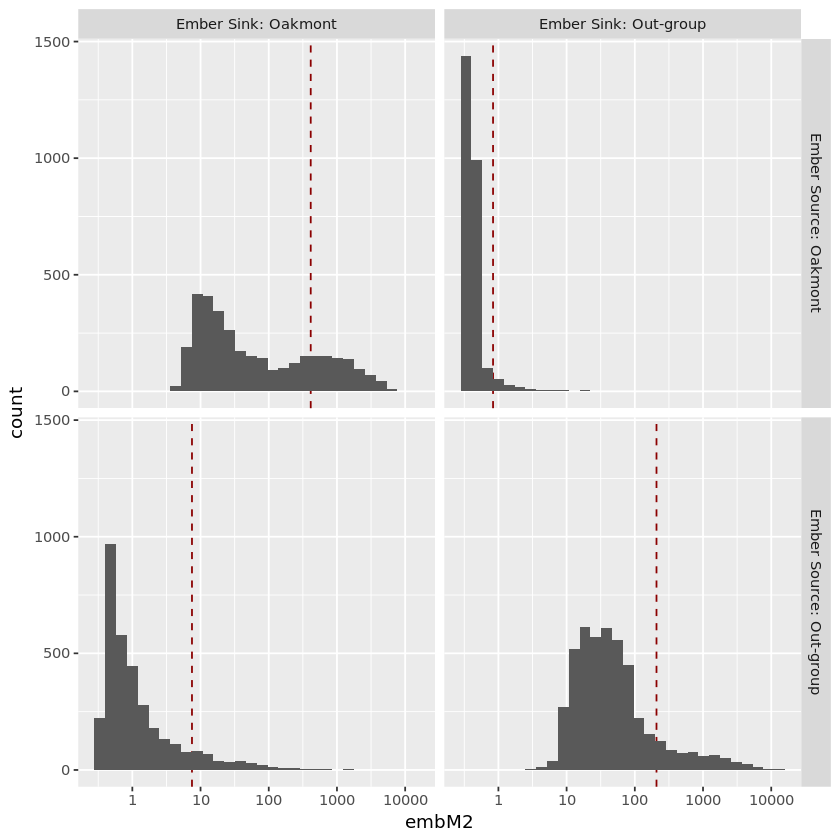

In [13]:
embernet_dt[Class_str_1 !='Structure',list(embM2 = sum(embers)/sum(area)),by=c('parno_2', 'source_CWO','sink_CWO')] %>%
ggplot(aes(x=embM2)) +
geom_vline(data=embernet_dt[Class_str_1 !='Structure',list(embM2 = sum(embers)/sum(area)),by=c('parno_2', 'source_CWO','sink_CWO')][,list(embM2 = mean(embM2)),by=c('source_CWO','sink_CWO')],aes(xintercept = embM2),linetype='dashed',color='darkred')+
geom_histogram() +
scale_x_continuous(trans='log10') +
facet_grid(paste0('Ember Source: ', source_CWO)~paste0('Ember Sink: ',sink_CWO))

In [14]:
oakmont_joined_sf <- 
data.table(
    oakmont_sf %>% data.table,
    oakmont_embernet_dt[match(oakmont_sf$parno,oakmont_embernet_dt$parno_2), ]) %>% st_as_sf()

In [15]:
oakmont_joined_sf %>% st_write('/work/embernet_outputs/temporary_embernet_results_oakmont.gpkg')

Layer temporary_embernet_results_oakmont in dataset /work/embernet_outputs/temporary_embernet_results_oakmont.gpkg already exists:
use either append=TRUE to append to layer or append=FALSE to overwrite layer


ERROR: Error in CPL_write_ogr(obj, dsn, layer, driver, as.character(dataset_options), : Dataset already exists.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5eceab32-5823-49b2-9c95-72828e51fba3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>